# 05-2 Image Based Recommender

In our final notebook, we demonstrate one more recommender system using image based data. The idea is:
1. Encode the images of our items into a latent vector.
2. Obtain a query image from the user. Encode this query image into a latent vector.
3. Compare the query vector against our inventory of latent vectors. Return the ones most similar.

Because of the size of the dataset, we restrict the scope of this recommender to one specific type of clothing: **dresses**.

In [1]:
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import save_image

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics.pairwise import cosine_similarity

import joblib

In [3]:
articles = pd.read_csv('../data/articles.csv')

In [4]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
articles.value_counts(subset='product_type_name')

product_type_name
Trousers        11169
Dress           10362
Sweater          9302
T-shirt          7904
Top              4155
                ...  
Bra extender        1
Blanket             1
Towel               1
Wood balls          1
Cushion             1
Length: 131, dtype: int64

In [6]:
dresses = articles[ articles['product_type_name'] == 'Dress']

dresses.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
204,192460006,192460,Knit dress,265,Dress,Garment Full body,1010016,Solid,8,Dark Grey,...,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,"Short, fine-knit dress with a hood, waterfall ..."
238,202017055,202017,Rihanna dress,265,Dress,Garment Full body,1010017,Stripe,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Short-sleeved dress in slub jersey with an ela...
261,212629004,212629,Alcazar strap dress,265,Dress,Garment Full body,1010016,Solid,9,Black,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,"Long, sleeveless dress in jersey with narrow s..."
262,212629031,212629,Alcazar strap dress,265,Dress,Garment Full body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,"Long, sleeveless dress in jersey with narrow s..."
263,212629032,212629,Alcazar strap dress,265,Dress,Garment Full body,1010016,Solid,53,Dark Pink,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,"Long, sleeveless dress in jersey with narrow s..."


In [7]:
dresses.value_counts(subset='index_group_name')

index_group_name
Ladieswear       5400
Baby/Children    2502
Divided          2460
dtype: int64

In [8]:
dresses = dresses[ dresses['index_group_name'] == 'Ladieswear' ]

dresses.shape

(5400, 25)

In [9]:
all_dress_ids = list(dresses['article_id'])

all_dress_ids[0:5]

[202017055, 220094001, 220094010, 220094011, 220094015]

In [10]:
dress_ids = []

for dress in all_dress_ids:
    id_string = '0'+str(dress)
    path = '../images/'+id_string[0:3]
    dir_list = os.listdir(path)
    if id_string+'.jpg' in dir_list:
        dress_ids.append(dress)

In [11]:
len(dress_ids)

5391

In [12]:
def get_image_path(article_id):
    
    prod_string = '0'+str(article_id)
    path = '../images/'+prod_string[0:3]+'/'+str(article_id)+'.jpg'
    
    return path
    

In [15]:
resizer = transforms.Compose([transforms.Resize((320,224))])

for dress in dress_ids:
    prod_string = '0'+str(dress)+'.jpg'
    path = '../images/'+prod_string[0:3]+'/'+prod_string
    img = read_image(path)
    
    if img.shape[1]<img.shape[2]:
        img = torch.transpose(img, 1, 2)
    
    img = resizer(img)
    img = torch.div(img, 255)
        
    save_image(img, '../images_dresses_320x224/'+prod_string)

---

In order to encode the image data into a vector (so that we may perform computations on similarity), we will pass the image data through the first half of the VGG-16 model. The VGG-16 model is a convolutional neural network originally trained to classify images across 1000 distinct categories.

Since we are not doing image classification, we do not need the full model. Instead, we will be borrowing the pre-trained convolutional base and use it as **feature extractor** for our image data.

In [36]:
vgg16_model = torchvision.models.vgg16(pretrained=True)

vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
# only use the convolutional base of VGG-16
model = vgg16_model.features

model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
model.to('cuda')

# we need to freeze the convolutional base (since we don't want to train or alter it in anyway).
# To do this in PyTorch, we just simply have to turn off the Autograd tracker.
for param in model.parameters():
    param.requires_grad = False

In [196]:
joblib.dump(model, '../models/vgg16_feature_extractor.pkl')

['../models/vgg16_feature_extractor.pkl']

In [101]:
# define a Dataset object. This allows us to control how the images are loaded into memory.
# We will load the images lazily (i.e. 1 at a time to avoid RAM issues).
class DressImageDataSet(Dataset):
    
    def __init__(self, image_dir, transform=None):
        self.dir_list = os.listdir(image_dir)
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dir_list)
    
    
    def __getitem__(self, idx):
        img_name = self.dir_list[idx]
        img_path = self.image_dir+'/'+self.dir_list[idx]
        image = read_image(img_path)
        image = torch.div(image,255)
        image.to('cuda')
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_name
    

In [134]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

dress_data = DressImageDataSet( image_dir='../images_dresses_320x224', transform=normalize)
dress_loader = DataLoader(dress_data, batch_size=1, shuffle=False)

- Let's quickly demonstrate an example of how this encoding will work. First we load an image as PyTorch tensor.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('0202017055.jpg',)


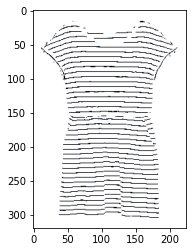

In [135]:
img, name = next(iter(dress_loader))

print(name)
plt.imshow(img[0].permute(1,2,0));

- Next we'll move the torch tensor to the GPU for computational speed, then feed it through the convolutional base.

In [136]:
test_vector = model(img.to('cuda'))

test_vector.shape

torch.Size([1, 512, 10, 7])

- The result is a 512 x 10 x 7 tensor. This is a stack of 10 x 7 matrices that's 512 layers deep. We will need to flatten this down into a single long vector.

In [137]:
flatten = nn.Flatten()

flatten((test_vector))[0].shape

torch.Size([35840])

- The result is a 35,840 dimensional vector.

With the single example worked out, let us repeat the process for all the dresses in our inventory.

In [221]:
data = []
names = []
flatten = nn.Flatten()

# pass each of the dresses through the convolutional base, encoding them into latent vectors
for (image, name) in dress_loader:
    temp_vec = model(image.to('cuda'))
    temp_vec = flatten(temp_vec)[0].to('cpu').numpy()
    data.append(temp_vec)
    names.append(name[0][0:10])

In [222]:
dress_encodings = pd.DataFrame(data, index=names)

In [223]:
dress_encodings.reset_index(inplace=True)

In [224]:
dress_encodings.rename(columns={'index':'article_id'},inplace=True)

In [225]:
dress_encodings.head()

,article_id,0,1,2,3,4,5,6,7,8,...,35830,35831,35832,35833,35834,35835,35836,35837,35838,35839
0,0202017055,0.0,0.451366,0.630429,0.0,0.0,0.0,0.0,0.0,0.0,...,0.225049,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0220094001,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0220094010,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0220094011,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0220094015,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
dress_encodings.iloc[0,0]

'0202017055'

In [227]:
dress_encodings.shape

(5391, 35841)

In [228]:
joblib.dump(dress_encodings, '../models/dress_encodings.pkl')

['../models/dress_encodings.pkl']

In [229]:
latent_vector = np.array(dress_encodings.iloc[0, 1:])

latent_vector

array([0.0, 0.45136577, 0.6304287, ..., 0.0, 0.0, 0.0], dtype=object)

Now, we want the user to be able to upload an image of a dress and query that image against our database of encoded dress vectors.

To demonstrate how we can do this, we found a dress from Google that is not in our inventory.
- We take the dress and encode into a latent vector using the VGG-16 convolutional base.
- We then compare query vector against our database of latent vectors using Cosine Similarity.
- Return the images with highest similarity score.

In [230]:
# define a function which loads an query image and encode it via VGG-16
def load_query(path=None):
    if path==None:
        filename = os.listdir('../image_query')[0]
        path = '../image_query/'+filename
    
    query = read_image(path)
    query = resizer(query)
    query = torch.div(query, 255)
    query = normalize(query).to('cuda')
    query = model(query)
    query = query.view(1, query.shape[0], query.shape[1], query.shape[2])
    query = flatten(query)[0].to('cpu').numpy()
    
    return query

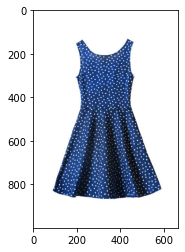

In [9]:
plt.imshow(mpimg.imread('../image_query/query.jpg'));

In [247]:
read_image('../image_query/query.jpg')

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)

In [231]:
query_image = load_query()

In [232]:
query_image.shape

(35840,)

In [233]:
# compute cosine similarity of query image against a specific image in our database
cosine_similarity(query_image.reshape(1, query_image.shape[0]), latent_vector.reshape(1, latent_vector.shape[0]))[0][0]

0.209788200866107

In [234]:
# repeat the above process and compute similarity against all dresses in our database.
similarities = []

for i in range(dress_encodings.shape[0]):
    article_id = dress_encodings.iloc[i,0]
    latent = np.array(dress_encodings.iloc[i, 1:])
    sim = cosine_similarity(query_image.reshape(1, query_image.shape[0]), latent.reshape(1, latent.shape[0]))[0][0]
    similarities.append([article_id, sim])
    

In [235]:
df = pd.DataFrame(similarities, columns=['article_id', 'similarity'])

In [237]:
# return the dresses most similary to query image
df.sort_values(by='similarity', ascending=False)

,article_id,similarity
3596,0810799002,0.620447
2412,0737098003,0.619930
2876,0764768005,0.561157
860,0617821002,0.560659
3390,0793962001,0.559066
...,...,...
1726,0683317001,0.072490
661,0606800002,0.069868
378,0568838004,0.065954
1505,0664060001,0.065759


---

- Functionally speaking, what we have effectively done is create a Google Image Search but for H&M dresses. This can be leveraged into a recommender system rather easily: just use the user's past purchases as the query image.
    - We demonstrate an implementation of this in our web application, although the search time is rather long (approx. 3 mins on an RTX 3090 and approx. 6 mins on a normal CPU).

- We can extend the functionality to other catogories of clothing: shows, tops, jackets, etc. Thus it might be possible to take the "style" of a past purchase and query other clothing types with the same style.
    - E.g. say a user buys a dress with a floral pattern. It might be possible to query tops with a floral pattern and return that as a recommendation to the user.